In [ ]:
!pip install qiskit ipywidgets # while working on google colab!

In [2]:
#from qbm_utils import *
from qiskit.quantum_info import Pauli
#from qiskit.extensions import UGate, RZZGate
from qiskit.circuit.library import RZZGate, UGate, MCXGate

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# first import qbm_utils.py from the project-repository. it is in the folder "qbm_codes"
from qbm_utils import * 

### Quantum enhanced MCMC implementation
Aim is to implement the circuit for implementing quantum enhanced MCMC

In [ ]:
import qiskit

### Define the model

In [ ]:
## put n_spins even always
# n_spins = 4

# ## construct problem Hamiltonian ##
# shape_of_J=(n_spins,n_spins)
# J =  np.random.randn(n_spins,n_spins)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
# J = 0.5 * (J + J.transpose() )
# h = np.random.randn(n_spins)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# # instantiate the model
# model = IsingEnergyFunction(J, h)

# alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )


### Quantum part!

In [5]:
def initialise_qc(n_spins:int, bitstring:str):
  '''
  Initialises a quantum circuit with n_spins number of qubits in a state defined by "bitstring"
  (Caution: Qiskit's indexing convention for qubits (order of tensor product) is different from the conventional textbook one!)  
  '''

  spins = QuantumRegister(n_spins, name= 'spin')
  creg_final = ClassicalRegister(n_spins, name= 'creg_f')
  qc_in = QuantumCircuit(spins, creg_final)

  len_str_in=len(bitstring)
  assert(len_str_in == len(qc_in.qubits)), "len(bitstring) should be equal to number_of_qubits/spins"

  #print("qc_in.qubits: ", qc_in.qubits)
  where_x_gate=[qc_in.qubits[len_str_in-1-i] for i in range(0,len(bitstring)) if bitstring[i]=='1']
  if len(where_x_gate)!=0:
    qc_in.x(where_x_gate)
  return qc_in

In [6]:
# quantum procedure to make transitions from s to s'
def run_qc_quantum_step(qc_initialised_to_s:QuantumCircuit, h, J, alpha,n_spins:int, num_trotter_steps=10, time=0.8)->str:

    '''     
    Takes in a qc initialized to some state "s". After performing unitary evolution U=exp(-iHt)
    , circuit is measured once and returns the bitstring ,s', corresponding to the measured state .

    Args:
    qc_initialised_to_s
    alpha:
    num_trotter_steps: (default 10)
    time: For how long you want to evolve.
    '''
    for _ in range(num_trotter_steps):
        append_evolution(qc_initialised_to_s, h, J ,gamma=np.random.random(), alpha=alpha, time=time)
    append_evolution(qc_initialised_to_s, h, J , gamma=0.1, alpha=alpha, time=time, is_terminal_step=True)
    
    # draw the ckt
    #print(qc_initialised_to_s.draw())

    # run the circuit
    #creg_final=ClassicalRegister(n_spins, name= 'creg_f')
    num_shots=1
    quantum_registers_for_spins=qc_initialised_to_s.qregs[0]
    classical_register=qc_initialised_to_s.cregs[0]
    qc_initialised_to_s.measure(quantum_registers_for_spins,classical_register)
    state_obtained_dict=execute(qc_initialised_to_s, shots= num_shots, backend= qsm).result().get_counts()
    state_obtained=list(state_obtained_dict.keys())[0]#since there is only one element
    return state_obtained

## Classical procedure for $s \to s^{'}$

In [7]:
def classical_transition(num_spins:int)->str:
    '''   
    Returns s' , obtained via uniform transition rule!
    '''
    num_elems=2**(num_spins)
    next_state=np.random.randint(0,num_elems)# since upper limit is exclusive and lower limit is inclusive
    bin_next_state=f'{next_state:0{num_spins}b}'
    return bin_next_state

## Step 2: Classical part: Accepting the state $s^{'}$

In [8]:
def classical_loop_accepting_state(s_init:str, s_prime:str,energy_s:float,energy_sprime:float,temp=1)->str:
    '''  
    Accepts the state sprime with probability A ( i.e. min(1,exp(-(E(s')-E(s))/ temp) ) 
    and s_init with probability 1-A
    '''
    delta_energy=energy_sprime-energy_s # E(s')-E(s)
    exp_factor=np.exp(-delta_energy/temp)
    acceptance=min(1,exp_factor)# for both QC case as well as uniform random strategy, the transition matrix Pij is symmetric!
    coin_flip=np.random.choice([True, False], p=[acceptance, 1-acceptance])
    new_state=s_init
    if coin_flip:
        new_state=s_prime
    
    return new_state

## Function to run MCMC

In [17]:
from collections import Counter
def classical_mcmc(N_hops:int, num_spins:int, num_elems:int, model, return_last_n_states=500):
    ''' 
    Args: 
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it! 
    '''
    states=[]
    current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    print("starting with: ", current_state) 
    for i in range(0, N_hops):
        #print("i:",i)
        states.append(current_state)
        # get sprime
        s_prime=classical_transition(num_spins)
        # accept/reject s_prime 
        energy_s=model.get_energy(current_state)
        energy_sprime=model.get_energy(s_prime)
        next_state= classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        current_state= next_state
    
    return Counter(states[-return_last_n_states:])# returns dictionary of occurences for last 500 states

In [18]:
from collections import Counter
def quantum_enhanced_mcmc(N_hops:int, num_spins:int, num_elems:int,model, h,J, alpha, num_trotter_steps=10, return_last_n_states=500):
    ''' 
    Args: 
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it! 
    '''
    states=[]
    current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    print("starting with: ", current_state) 
    # initialise quantum circuit to current_state
    qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    #print("qc_s is:"); print(qc_s.draw())
    for i in range(0, N_hops):
        #print("i: ", i)
        states.append(current_state)
        # get sprime
        s_prime=run_qc_quantum_step(qc_initialised_to_s=qc_s, h=h, J=J, alpha=alpha, n_spins=num_spins, num_trotter_steps=num_trotter_steps, time=0.8)
        # accept/reject s_prime 
        energy_s=model.get_energy(current_state)
        energy_sprime=model.get_energy(s_prime)
        next_state= classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        if current_state!=next_state:
          current_state= next_state
        qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    
    return Counter(states[-return_last_n_states:])# returns dictionary of occurences for last 500 states

# Run MCMC using classical rule

## Define your model

In [19]:
# define the model
## put n_spins even always
n_spins = 4

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)
J =  np.random.randn(n_spins,n_spins)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
h = np.random.randn(n_spins)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# instantiate the model
model = IsingEnergyFunction(J, h)

alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )


In [ ]:
# just checking something
# qr = QuantumRegister(3, 'q')
# anc = QuantumRegister(1, 'ancilla')
# cr = ClassicalRegister(3, 'c')
# qc = QuantumCircuit(qr, anc, cr)

# qc.x(anc[0])
# qc.h(anc[0])
# qc.h(qr[0:3])
# qc.cx(qr[0:3], anc[0])
# qc.h(qr[0:3])
# qc.barrier(qr)
# # qc.measure(qc.qregs, qc.cregs)
# print("qr is:", qr); print("cr is:", cr)
# print("qc.qregs is:", qc.qregs)
# print("qc.qregs is:", qc.cregs)

# job = execute(qc, backend=qsm, shots=4321)


In [12]:
# an example # just checking something!
k=initialise_qc(n_spins=4,bitstring='1011')
print("k.qregs:",k.qregs)
print("_"*10)
print("k.cregs:",k.cregs)

print(k.draw())
state_check=run_qc_quantum_step(qc_initialised_to_s=k, h=h, 
J=J, alpha=alpha,n_spins=4, 
num_trotter_steps=10, time=0.8)
print(state_check)


k.qregs: [QuantumRegister(4, 'spin')]
__________
k.cregs: [ClassicalRegister(4, 'creg_f')]
          ┌───┐
  spin_0: ┤ X ├
          ├───┤
  spin_1: ┤ X ├
          └───┘
  spin_2: ─────
          ┌───┐
  spin_3: ┤ X ├
          └───┘
creg_f: 4/═════
               
1011


In [13]:
from qiskit.visualization import plot_histogram

### 1. Run classical mcmc with uniform transition strategy

starting with:  0110


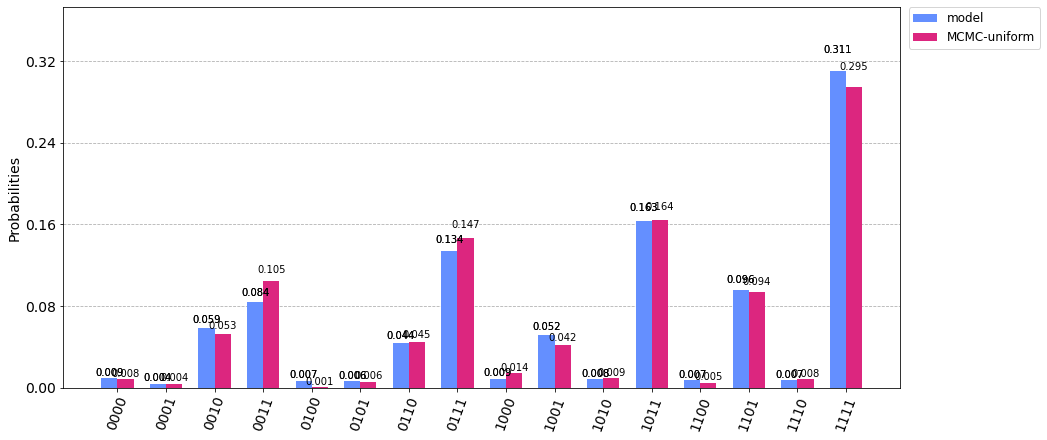

In [20]:
# symmetric uniform transition matrix for uniform transition rule
num_spins=4
num_elems=2**(num_spins)
transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
np.fill_diagonal(transit_mat, 1./2)

# Run MCMC with uniform random transition strategy
N_hops=1000
dict_states_mcmc=classical_mcmc(N_hops, num_spins, num_elems,model, return_last_n_states=1000)

# get actual probability distribution
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in dict_states_mcmc.keys() ] )
# plot actual prob distribution as well as one obtained from MCMC
plot_histogram( [transits_bltz, dict_states_mcmc] , figsize=(15, 7), legend= ['model', 'MCMC-uniform' ])#, sort= 'value_desc')

### 2. Run Quantum Enchanced MCMC

starting with:  1000


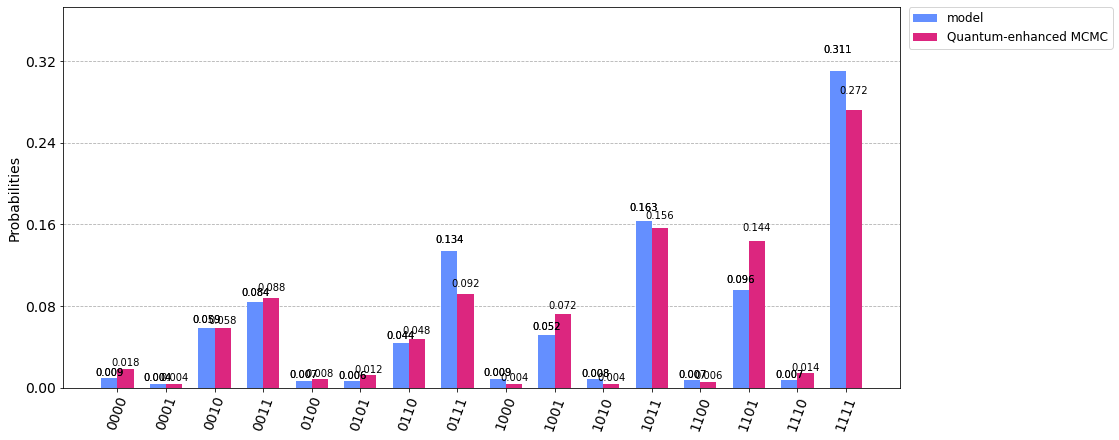

In [21]:
# symmetric uniform transition matrix for uniform transition rule
num_spins=4
num_elems=2**(num_spins)
transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
np.fill_diagonal(transit_mat, 1./2)

# Run MCMC with uniform random transition strategy
N_hops=1000
dict_states_quantum_mcmc=quantum_enhanced_mcmc(N_hops, num_spins, num_elems, model, h, J, alpha, num_trotter_steps=10, return_last_n_states=500)

# get actual probability distribution
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in dict_states_quantum_mcmc.keys() ] )
# plot actual prob distribution as well as one obtained from MCMC
plot_histogram( [transits_bltz, dict_states_quantum_mcmc] , figsize=(15, 7), legend= ['model', 'Quantum-enhanced MCMC' ])#, sort= 'value_desc')

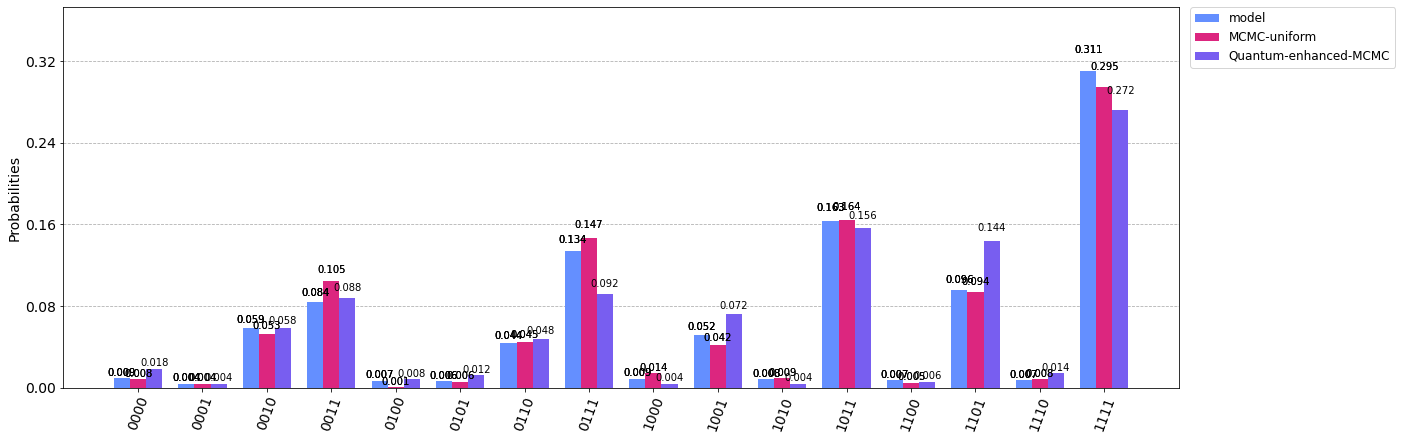

In [25]:
plot_histogram( [transits_bltz, dict_states_mcmc, dict_states_quantum_mcmc] , figsize=(20, 7), legend= ['model', 'MCMC-uniform', 'Quantum-enhanced-MCMC' ])

In [ ]:
# num_trotter_steps = 5
# for step in range(num_trotter_steps):
#     append_evolution(qc, h, J, gamma= np.random.random(), alpha= alpha, time= 0.8)
# append_evolution(qc, h, J, gamma= 0.1, alpha= alpha, time= 0.8, is_terminal_step= True)
# qc.draw("mpl")

# qc_i = qc.copy()
# shots = 10000
# qc.measure(spins, creg_final)
# counts =  execute(qc, shots= shots, backend= qsm).result().get_counts() 

# transits_exp = dict( [ (item[0].split(' ')[0], item[1]/shots ) for item in counts.items() ] )
# transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in transits_exp.keys() ] )

#plot_histogram( [transits_bltz, transits_exp ] , figsize=(25, 16), sort= 'value_desc', legend= ['model', 'sample' ])